In [ ]:
# Instalação de algumas dependencias

#!pip install numpy pandas matplotlib seaborn language-tool-python nltk spacy
#!python -m spacy download pt_core_news_sm


In [172]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import language_tool_python

from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
nlp = spacy.load('pt_core_news_sm')

In [ ]:
# dataset pode ser baixado no link: https://github.com/rafaelanchieta/essay
path = 'essay-br/'

essay_br_df = pd.read_csv(os.path.join(path, 'essay-br.csv'), converters={'essay': eval, 'competence': eval})
                       
prompts_df = pd.read_csv(os.path.join(path, 'prompts.csv'), index_col=0)

# Informações básicas dos Datasets (Redações e Prompts(temas))

In [164]:
essay_br_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      4570 non-null   int64 
 1   title       3886 non-null   object
 2   essay       4570 non-null   object
 3   competence  4570 non-null   object
 4   score       4570 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 178.6+ KB


In [165]:
essay_br_df['essay']

0       [A grande importância dos caminhoneiros para o...
1       [O senhor e eu já estamos cientes do projeto d...
2       [É de conhecimento geral dos brasileiros o quã...
3       [Podemos perceber que a sociedade brasileira e...
4       [Comenta-se que o ex presidente Lula ex-presid...
                              ...                        
4565    [Em constante evolução tecnológica , o mundo e...
4566    [“O importante da vida não é viver, mas viver ...
4567    [O esporte – seja qual for – é comporto por re...
4568    [José Saramago, proeminente escritor e dramatu...
4569    [O influenciador digital é uma profissão de gr...
Name: essay, Length: 4570, dtype: object

In [166]:
prompts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 85
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  86 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


# Pré Processamento e validações do Dataset
- Verificar se nota das competências está de acordo com a nota total
- Formatar texto em string única (dataset apresenta o texto como uma lista de parágrafos)
- Atribuir colunas individuais para nota de cada competência
- Limpar parágrafos vazios

In [167]:
try:
    competence_cols = [f'C{i+1}' for i in range(5)]
    essay_br_df[competence_cols] = pd.DataFrame(essay_br_df['competence'].tolist(), index=essay_br_df.index)
    
    essay_br_df['C_sum'] = essay_br_df[competence_cols].sum(axis=1)
    sum_diff = (essay_br_df['score'] - essay_br_df['C_sum']).abs().sum()
    print(f"\nSoma absoluta da diferença entre 'score' e a soma das competências: {sum_diff}")
    if sum_diff > 1e-6:
        print("AVISO: A coluna 'score' não corresponde exatamente à soma das competências em alguns casos")
    
    print("\nPrimeiras linhas com notas de competência extraídas:")
    print(essay_br_df[['score'] + competence_cols + ['C_sum']].head())
except Exception as e:
    print(f"\nErro ao processar a coluna 'competence': {e}")


def clean_short_paragraphs(essay, min_tokens=5):
    """Remove parágrafos com menos de `min_tokens` tokens."""
    if not isinstance(essay, list):
        return essay 
    
    cleaned_paragraphs = []
    for paragraph in essay:
        tokens = word_tokenize(paragraph)
        if len(tokens) >= min_tokens:
            cleaned_paragraphs.append(paragraph)
    
    return cleaned_paragraphs if cleaned_paragraphs else essay

# Aplicar a limpeza antes de computar estatísticas
essay_br_df['essay'] = essay_br_df['essay'].apply(clean_short_paragraphs)

def format_essay(paragraphs):
    if isinstance(paragraphs, list):
        return '\n\n'.join(paragraphs).strip()
    return str(paragraphs)

essay_br_df['essay_fulltext'] = essay_br_df['essay'].apply(format_essay)


Soma absoluta da diferença entre 'score' e a soma das competências: 0

Primeiras linhas com notas de competência extraídas:
   score   C1   C2   C3   C4   C5  C_sum
0    680  160  160  120  120  120    680
1    680  160  160  120  120  120    680
2    720  120  160  160  160  120    720
3    560  120  120   80  120  120    560
4      0    0    0    0    0    0      0


# Análise das Notas
- Analisamos a distribuição da nota total e das notas por competência.
- Notas por competência devem ter os valores de acordo com a gradação do ENEM (0,40,80,120,160,200)

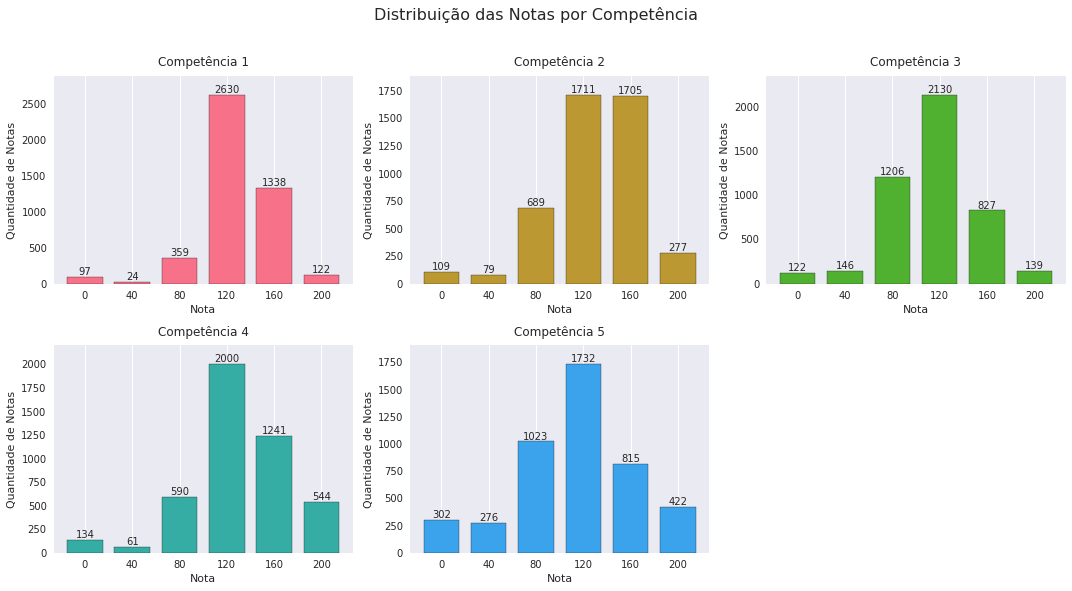

<Figure size 864x432 with 0 Axes>

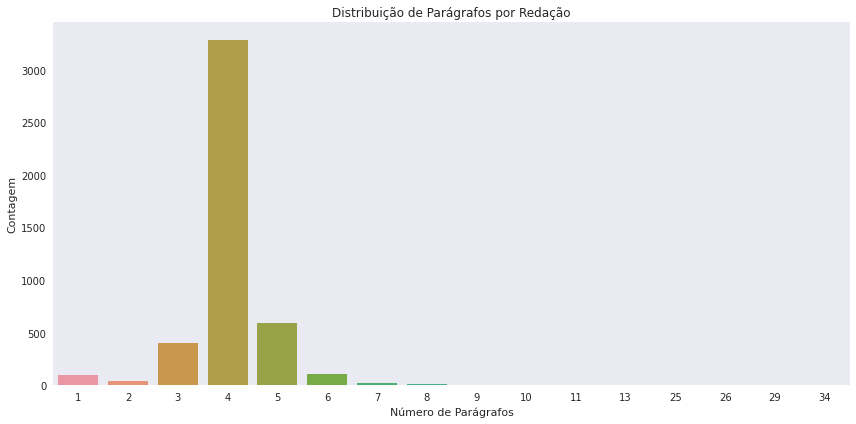

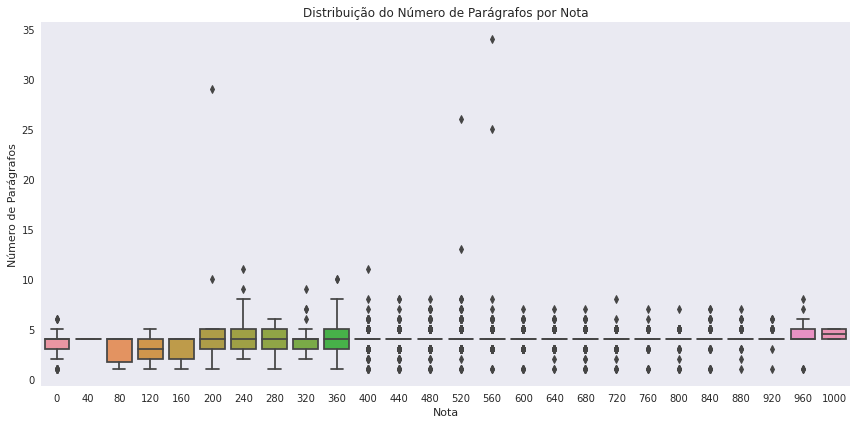

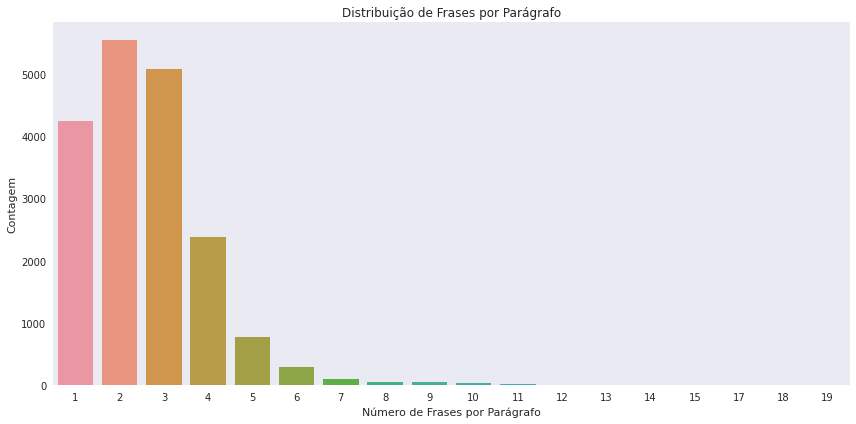

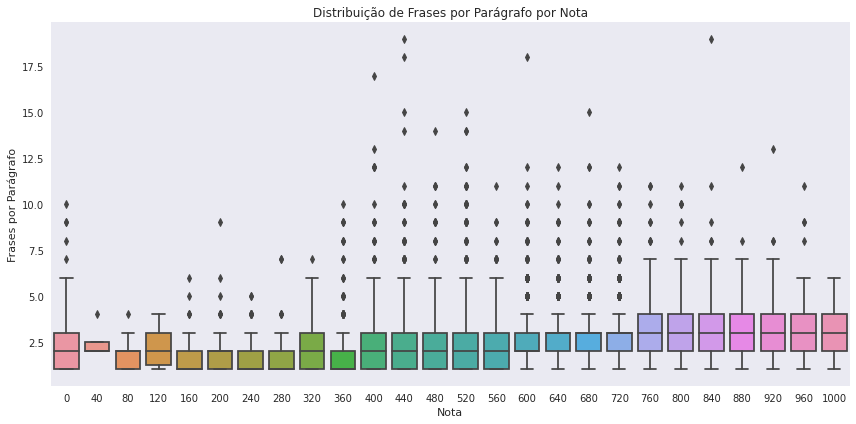

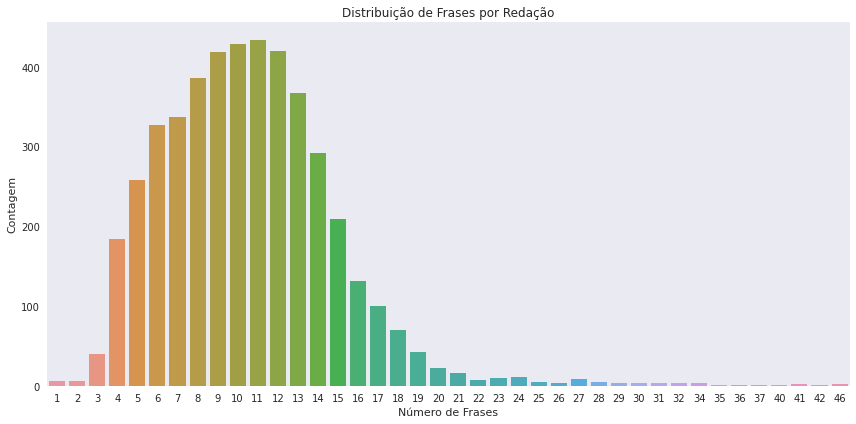

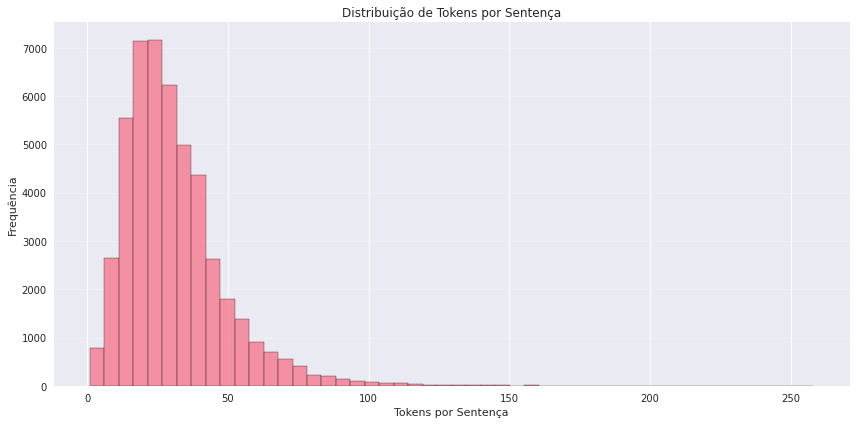

In [168]:
# Distribuição das Notas por Competência (C1-C5)
plt.figure(figsize=(15, 8))
plt.suptitle('Distribuição das Notas por Competência', fontsize=16, y=1.02)

notas_enem = [0, 40, 80, 120, 160, 200]

for i, col in enumerate(competence_cols, 1):
    plt.subplot(2, 3, i)
    
    counts = essay_br_df[col].value_counts().reindex(notas_enem, fill_value=0)
    
    bars = plt.bar(notas_enem, counts, width=30, color=f'C{i-1}', edgecolor='black')
    
    # Adicionando os valores em cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.title(f'Competência {i}', pad=10)
    plt.xlabel('Nota')
    plt.ylabel('Quantidade de Notas')
    plt.xticks(notas_enem)
    plt.grid(axis='y', alpha=0.3)
    
    plt.margins(y=0.1)

plt.tight_layout()
plt.show()

def compute_stats(essay):
    if not isinstance(essay, list):
        return {
            'n_paragrafos': 0,
            'n_frases': 0,
            'tokens_por_frase': [],
            'tokens_por_paragrafo': 0,
            'tokens_total': 0
        }

    parrafos = essay
    n_paragrafos = len(parrafos)
    frases_por_paragrafo = []
    tokens_por_frase = []

    total_tokens = 0

    for p in parrafos:
        frases = sent_tokenize(p)
        frases_por_paragrafo.append(len(frases))
        for f in frases:
            tokens = word_tokenize(f)
            total_tokens += len(tokens)
            tokens_por_frase.append(len(tokens))

    tokens_por_paragrafo = total_tokens / (n_paragrafos + 1e-6)

    return {
        'n_paragrafos': n_paragrafos,
        'n_frases': sum(frases_por_paragrafo),
        'frases_por_paragrafo': frases_por_paragrafo,
        'tokens_por_frase': tokens_por_frase,
        'tokens_por_paragrafo': tokens_por_paragrafo,
        'tokens_total': total_tokens
    }

estatisticas = essay_br_df['essay'].apply(compute_stats)

essay_br_df['n_paragrafos'] = estatisticas.apply(lambda x: x['n_paragrafos'])
essay_br_df['n_frases'] = estatisticas.apply(lambda x: x['n_frases'])
essay_br_df['tokens_total'] = estatisticas.apply(lambda x: x['tokens_total'])


plt.figure(figsize=(12, 6))   

# Distribuição de parágrafos
plt.figure(figsize=(12, 6))   
sns.countplot(data=essay_br_df, x='n_paragrafos')
plt.title('Distribuição de Parágrafos por Redação')
plt.xlabel('Número de Parágrafos')
plt.ylabel('Contagem')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# número de paragrafos deve estar relacionado a estrutura do texto dissertativo-argumentativo
plt.figure(figsize=(12, 6))

sns.boxplot(data=essay_br_df, x='score', y='n_paragrafos')

plt.title('Distribuição do Número de Parágrafos por Nota')
plt.xlabel('Nota')
plt.ylabel('Número de Parágrafos')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Distribuição de frases por parágrafo
# muitas frases por paragrafo pode indicar falta de clareza na argumentação

frases_por_paragrafo_flat = [n_frases for stats in estatisticas for n_frases in stats['frases_por_paragrafo']]

plt.figure(figsize=(12, 6))
sns.countplot(x=frases_por_paragrafo_flat)
plt.title('Distribuição de Frases por Parágrafo')
plt.xlabel('Número de Frases por Parágrafo')
plt.ylabel('Contagem')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

frases_por_paragrafo_df = essay_br_df[['score']].copy()
frases_por_paragrafo_df['frases_por_paragrafo'] = estatisticas.apply(lambda x: x['frases_por_paragrafo'])
frases_por_paragrafo_df = frases_por_paragrafo_df.explode('frases_por_paragrafo')
frases_por_paragrafo_df['frases_por_paragrafo'] = frases_por_paragrafo_df['frases_por_paragrafo'].astype(int)

plt.figure(figsize=(12, 6))
sns.boxplot(data=frases_por_paragrafo_df, x='score', y='frases_por_paragrafo')

plt.title('Distribuição de Frases por Parágrafo por Nota')
plt.xlabel('Nota')
plt.ylabel('Frases por Parágrafo')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Distribuição de frases por redação

plt.figure(figsize=(12, 6))
sns.countplot(data=essay_br_df, x='n_frases')
plt.title('Distribuição de Frases por Redação')
plt.xlabel('Número de Frases')
plt.ylabel('Contagem')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Distribuição de tokens por sentença
tokens_por_frase_flat = [token for stats in estatisticas for token in stats['tokens_por_frase']]

plt.figure(figsize=(12, 6))
sns.histplot(tokens_por_frase_flat, bins=50, kde=False)
plt.title('Distribuição de Tokens por Sentença')
plt.xlabel('Tokens por Sentença')
plt.ylabel('Frequência')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



- Textos com notas mais altas costumam ter ao menos 4 parágrafos, mostrando uma estrutura mínima consistente. Além disso, há uma tendência de aumento no número de frases por parágrafo com a nota, mas esse crescimento parece ter um limite, parágrafos muito longos, com muitas frases, não garantem notas mais altas e podem até prejudicar a clareza.

- Também podemos perceber alguns outliers no número de parágrafos e frases, o que pode indicar algum problema na hora de coletar ou processar as redações.

In [169]:
# redação outlier com 34 paragrafos
ids_suspeitos = essay_br_df[
    (essay_br_df['n_paragrafos'] == 34)
].index.unique() 

redacoes_suspeitas = essay_br_df.loc[ids_suspeitos, ['essay_fulltext', 'score']]

for idx, row in redacoes_suspeitas.iterrows():
    print(f"\n--- Redação ID {idx} (Nota {row['score']}) ---")
    print(row['essay_fulltext'])
    print("\n" + "="*50)


--- Redação ID 1390 (Nota 560) ---
José de Alencar e outros autores do romance indianista nos fizeram conhecer e

entender a relação do índio com a natureza: subsistência, exploração saudável

e freada, cooperação. Esse modo de se utilizar da fauna e da flora, no entanto,

não é o mais prevalecente no mundo, já que o homem, desde muito antes

de essas histórias serem contadas, tm para si duas únicas palavras-chave:

desenvolvimento e lucro. A fim de satisfazer essas necessidades inventadas,

viemos  explorando, desenfreada e irresponsavelmente, a natureza, sem

pensar que – um dia – a humanidade pode ser engolida por essas ações, como

recentes acontecimentos vêm sugerindo.

Primeiramente, é preciso compreender de que maneira ocorre a exploração

de bens naturais. Viemos retirando do meio ambiente muito mais do que

necessitamos, muito mais do que o imprescindível para a vida, isso porque nosso modo de viver está intimamente associado ao que é supérfluo. Se necessitamos, por exemplo, 

 - Redação parece estar com os parágrafos "quebrados", indicando algum problema na forma de obtenção das redações

In [ ]:
def detect_voz_passiva(texto):
    doc = nlp(texto)
    voz_passiva = 0
    voz_ativa = 0

    for sent in doc.sents:
        for token in sent:
            # Detecta voz passiva: sujeito passivo + verbo auxiliar (ser) + particípio
            if token.dep_ == 'aux:pass' or (token.head.pos_ == 'VERB' and 'Pass' in token.head.morph.get('Voice')):
                voz_passiva += 1
                break  # conta uma vez por sentença
            # Se não for passiva e tiver sujeito + verbo, conta como ativa
            elif token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
                voz_ativa += 1
                break

    return {
        'voz_passiva': voz_passiva,
        'voz_ativa': voz_ativa,
        'proporcao_passiva': voz_passiva / (voz_passiva + voz_ativa + 1e-6)
    }

voz_data = essay_br_df['essay_fulltext'].apply(detect_voz_passiva)

essay_br_df['voz_passiva'] = voz_data.apply(lambda x: x['voz_passiva'])
essay_br_df['voz_ativa'] = voz_data.apply(lambda x: x['voz_ativa'])
essay_br_df['passiva_ratio'] = voz_data.apply(lambda x: x['proporcao_passiva'])

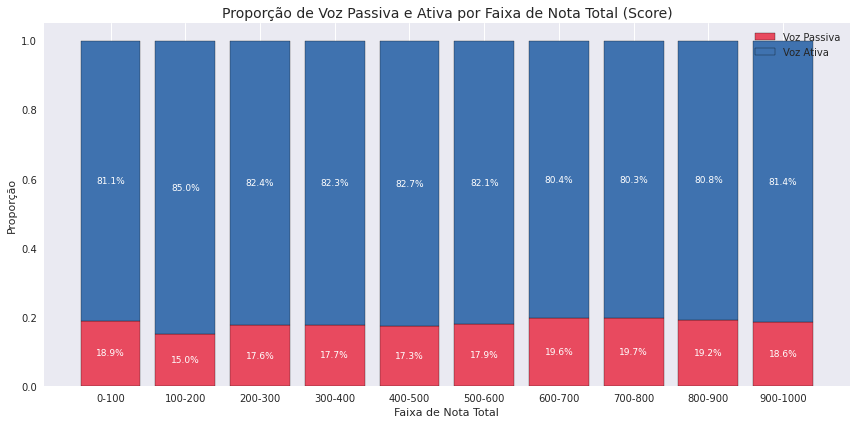

In [175]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', 
          '500-600', '600-700', '700-800', '800-900', '900-1000']

essay_br_df['score_bin'] = pd.cut(essay_br_df['score'], bins=bins, labels=labels, right=False)

voz_aggregated = essay_br_df.groupby('score_bin')[['voz_passiva', 'voz_ativa']].sum().fillna(0)

voz_prop = voz_aggregated.div(voz_aggregated.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
bars = plt.bar(voz_prop.index, voz_prop['voz_passiva'], color='#E84A5F', edgecolor='black', label='Voz Passiva')
bars2 = plt.bar(voz_prop.index, voz_prop['voz_ativa'], bottom=voz_prop['voz_passiva'], color='#3F72AF', edgecolor='black', label='Voz Ativa')

for i, (p, a) in enumerate(zip(voz_prop['voz_passiva'], voz_prop['voz_ativa'])):
    plt.text(i, p/2, f'{p*100:.1f}%', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, p + a/2, f'{a*100:.1f}%', ha='center', va='center', fontsize=9, color='white')

plt.title('Proporção de Voz Passiva e Ativa por Faixa de Nota Total (Score)', fontsize=14)
plt.xlabel('Faixa de Nota Total')
plt.ylabel('Proporção')
plt.ylim(0, 1.05)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

- Proporção de uso de voz passiva e ativa parece se manter constante entre todas as faixas de notas

In [193]:
tool = language_tool_python.LanguageTool('pt-BR')

erros_ids_filtrados = [
    'COMMA_PARENTHESIS_WHITESPACE',
    'SPACE_BEFORE_PUNCTUATION', 
    'SPACE_BEFORE_PUNCTUATION2', 
    'SENTENCE_WHITESPACE', 
    'ESPACO_DUPLO',
    'WHITESPACE_RULE',
    'PARENTESESE_AND_QUOTES_SPACING'
]

tool.disabled_rules.update(erros_ids_filtrados)

In [ ]:
def analisar_erros(texto):
    erros = tool.check(texto)
    return {
        'qtd_erros': len(erros),
        'lista_erros': erros
    }

# Aplica a função
erros_data = essay_br_df['essay_fulltext'].apply(analisar_erros)

# Cria duas colunas no DataFrame
essay_br_df['qtd_erros'] = erros_data.apply(lambda x: x['qtd_erros'])
essay_br_df['lista_erros'] = erros_data.apply(lambda x: x['lista_erros'])


    score      mean  count   sum
0       0  5.926829     82   486
1      40  2.000000      1     2
2      80  2.833333      6    17
3     120  6.666667      6    40
4     160  6.263158     19   119
5     200  8.523810     21   179
6     240  6.393939     33   211
7     280  5.892857     28   165
8     320  6.420000     50   321
9     360  7.000000     63   441
10    400  6.346341    205  1301
11    440  6.149533    214  1316
12    480  6.025180    278  1675
13    520  6.162371    388  2391
14    560  5.467049    349  1908
15    600  6.013468    594  3572
16    640  5.636678    289  1629
17    680  6.366803    488  3107
18    720  5.926768    396  2347
19    760  5.436364    275  1495
20    800  5.274648    284  1498
21    840  5.940887    203  1206
22    880  5.854305    151   884
23    920  4.077778     90   367
24    960  3.636364     33   120
25   1000  2.791667     24    67


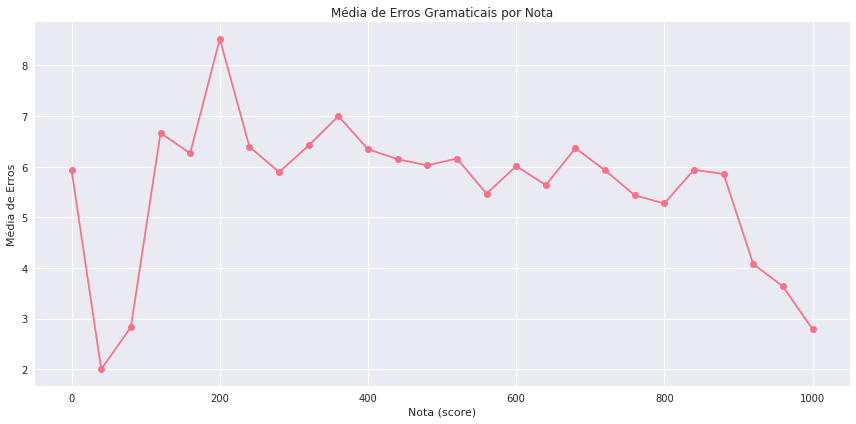

In [ ]:
distribuicao_erros = essay_br_df.groupby('score')['qtd_erros'].agg(['mean', 'count', 'sum']).reset_index()
print(distribuicao_erros)

plt.figure(figsize=(12,6))
plt.plot(distribuicao_erros['score'], distribuicao_erros['mean'], marker='o')
plt.title('Média de Erros Gramaticais por Nota')
plt.xlabel('Nota (score)')
plt.ylabel('Média de Erros')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
erros_explodidos = essay_br_df[['score_bin', 'lista_erros']].explode('lista_erros')
erros_explodidos = erros_explodidos[erros_explodidos['lista_erros'].notnull()]
erros_explodidos['ruleId'] = erros_explodidos['lista_erros'].apply(lambda x: x.ruleId if x else None)
frequencia_erros = erros_explodidos.groupby(['score_bin', 'ruleId']).size().reset_index(name='frequencia')
top_erros = frequencia_erros.groupby('ruleId')['frequencia'].sum().nlargest(10).index
frequencia_top = frequencia_erros[frequencia_erros['ruleId'].isin(top_erros)]
pivot_top = frequencia_top.pivot(index='score_bin', columns='ruleId', values='frequencia').fillna(0)


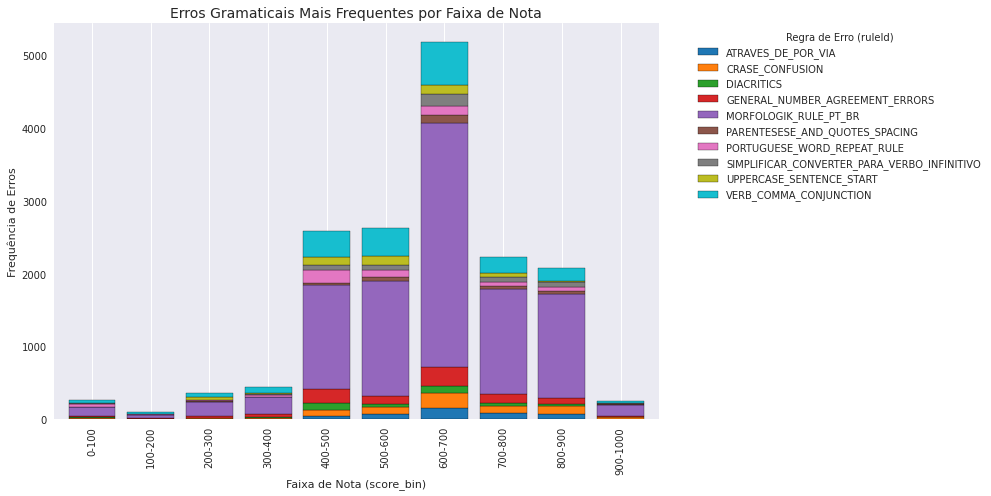

In [ ]:
# pivot_top.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', width=0.8, figsize=(14, 7))

# plt.title('Erros Gramaticais Mais Frequentes por Faixa de Nota', fontsize=14)
# plt.xlabel('Faixa de Nota (score_bin)')
# plt.ylabel('Frequência de Erros')
# plt.legend(title='Regra de Erro (ruleId)', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.show()

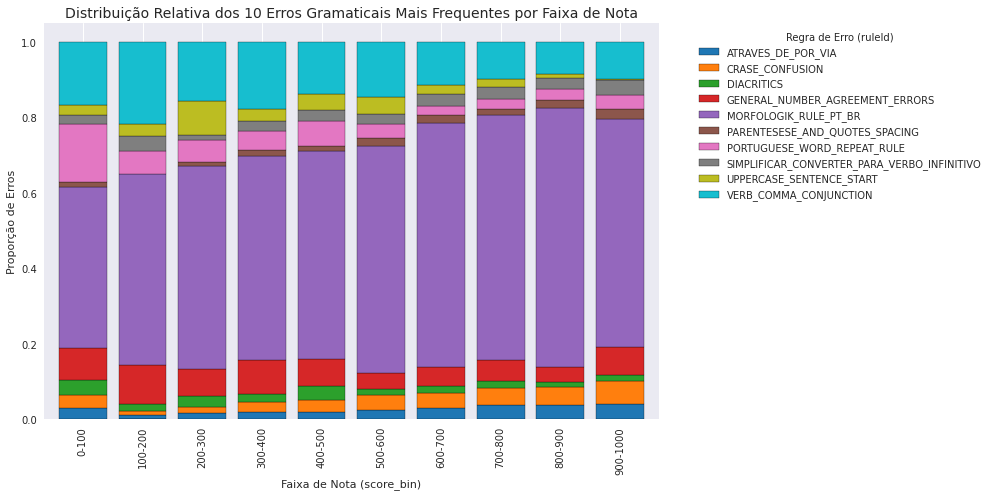

In [ ]:
# Normalizar por linha (score_bin) para ver proporção dos erros
pivot_top_percent = pivot_top.div(pivot_top.sum(axis=1), axis=0)

# Plotando o gráfico com proporções
pivot_top_percent.plot(
    kind='bar',
    stacked=True,
    colormap='tab10',
    edgecolor='black',
    width=0.8,
    figsize=(14, 7)
)

plt.title('Distribuição Relativa dos 10 Erros Gramaticais Mais Frequentes por Faixa de Nota', fontsize=14)
plt.xlabel('Faixa de Nota (score_bin)')
plt.ylabel('Proporção de Erros')
plt.legend(title='Regra de Erro (ruleId)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# verificar erros em redações nota mil

def exibir_erros(texto):
    erros = tool.check(texto)
    #erros = [erro for erro in erros if erro.ruleId not in erros_ids_filtrados]
    print("\nTexto:")
    print(texto)
    if erros:
        print("\nErros encontrados:")
        for erro in erros:
            inicio = erro.offset
            fim = inicio + erro.errorLength
            trecho_com_erro = texto[inicio:fim]
            print(f"- {erro.ruleId}: {erro.message}")
            print(f"  Trecho com erro: '{trecho_com_erro}'")
            if erro.replacements:
                print(f"  Sugestão: {', '.join(erro.replacements)}")
            print(f"  Posição: {inicio} a {fim}")
    else:
        print("\nNenhum erro encontrado.")
    print("\n" + "="*50 + "\n")

redacoes_pontuacao_maxima = essay_br_df[essay_br_df['score'] == 1000]

for _, row in redacoes_pontuacao_maxima.iterrows():
    exibir_erros(row['essay_fulltext'])



Texto:
A epidemia global de sobrepeso e obesidade vem se intensificando na maioria dos países como consequência principalmente da mudança de hábitos alimentares e comportamentais das últimas décadas e do aumento da disponibilidade de comida rápida, barata e altamente processada.

Com a intensa globalização, os hábitos de vida das pessoas sofreram grandes transformações. Aplicativos de entrega rápida, maior socialização online, trabalho em casa ou mais restrito à cadeira em frente a um computador; todas essas mudanças diminuíram a necessidade de locomoção e, consequentemente, o esforço e gasto calórico, de acordo com pesquisa da London School of Economics (LSE). É visível , ainda, a relação com alteração da qualidade do sono, pois esse vem sendo interrompido por notificações de celular, por exemplo, interferindo na produção de hormônio melatonina, responsável pelo sono reparador. Assim, a pessoa acorda cansada, e com necessidade de consumir alimentos energéticos, contribuindo para a es

# Algumas Considerações e Ponderações:

1) Como é feito o envio das redações dos usuários?

- Tentei fazer uma análise de erros gramaticais usando a ferramenta language_tool_python e encontrei muitos "erros" relacionados a espaçamento
- Alguns outliers com número muito elevado de paragrafos
- Isso sugere problemas na captura das redações, que podem ter sido submetidas a alguma ferramenta de transcrição e isso gerou esses erros


2) A etapa de identificação de erros gramaticais/ortográficos parece ser um grande desafio, ferramentas como o Language Tools apontam erros inexistentes, ex:
 - siglas e nomes próprios são marcados como erros ortográficos (regra MORFOLOGIK_RULE_PT_BR). Talvez utilizar reconhecimento de entidades nomeadas para desconsiderar os erros nesses casos
 - identificação de erros de concordância inexistentes, etc


3) Dataset tem apenas as notas, seria útil ter correções detalhadas para treinar modelos de identificação dos desvios que foram considerados

